(simple-simulation)=
# Simple simulation

In this task, we'll go through the basics of FESTIM and run a simple simulation on a 1D domain.

The very first step is to import the `festim` package:

In [1]:
import festim as F

print(F.__version__)

2.0a2


Every FESTIM model is represented by a `Simulation` object. Here, we give it the name `my_model`

In [2]:
my_model = F.HydrogenTransportProblem()

Several "ingredients" are now required to run a FESTIM simulation:
- a mesh
- a temperature
- a set of materials
- optionally: trapping properties
- boundary conditions
- optionally: sources of H
- simulation settings
- a stepsize for transient problems

## 1. Mesh

FESTIM simulations need a mesh. FESTIM provides support for simple 1D meshes. More complicated meshes can be imported from external software (see [](heat_transfer_sims)).

The most straightforward mesh is `MeshFromVertices`, which takes a `vertices` argument.

Numpy can be used to generate heavier meshes. Here we create a mesh containing 1000 cells over a [0, 7e-6] domain (7 microns).

This mesh is assigned to  the simulation by setting the `.mesh` attribute of `my_model`.

In [4]:
import numpy as np

my_model.mesh = F.Mesh1D(vertices=np.linspace(0, 7e-6, num=1001))

```{admonition} Tip
:class: tip
For more information on meshes in FESTIM. See the Meshing section of the tutorials.
```

## 2. Materials

`Material` objects hold the materials properties like diffusivity and solubility.

Here we only need the diffusivity defined as an Arrhenius law:

$$
    D = D_0 \exp{(-E_D/k_B T)}
$$

where $k_B$ is the Boltzmann constant in eV/K and $T$ is the temperature in K. From this, the pre-exponential coefficient, $D_0$ in m<sup>2</sup>/s, and the diffusion actiavtion energy, $E_D$ in eV are needed.

```{note} Note
All units in FESTIM as SI (apart for activation energies that are in eV)
To check what unit is expected by FESTIM, check the documentation. [Here](https://festim.readthedocs.io/en/latest/api/festim.materials.html#festim.materials.material.Material) is the reference for the `Material` class
```

In [5]:
mat = F.Material(D_0=1e-7, E_D=0.2)

volume_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, 7e-6], material=mat)
boundary_left = F.SurfaceSubdomain1D(id=1, x=0)
boundary_right = F.SurfaceSubdomain1D(id=2, x=7e-6)
my_model.subdomains = [volume_subdomain, boundary_left, boundary_right]

In [6]:
H = F.Species("H")
my_model.species = [H]

## 3. Temperature

Temperature is a very important parameter in hydrogen transport.
The value can be a simple float (like here `300`) or a `sympy` expression like `500 + 3*sympy.exp(-F.x)`.

The temperature is in K.

```{note} Note
For heat transfer simulations, the `HeatTransferProblem` can be used instead. See [Heat transfer simulations](heat_transfer_sims)
```

In [7]:
my_model.temperature = 300

## 4. Boundary conditions & source

Our hydrogen transport problem now needs boundary conditions and a volumetric source term.

FESTIM provides plenty of boundary conditions (see [Dirichlet BCs](https://festim.readthedocs.io/en/latest/api/festim.boundary_conditions.dirichlets.html#festim-boundary-conditions-dirichlets-package) and [Fluxes](https://festim.readthedocs.io/en/latest/api/festim.boundary_conditions.fluxes.html)).

Here we'll simply set the mobile concentration at ``1e15`` on the left and right boundaries (resp. `1` and `2`).

- ``field`` represents the variable on which the boundary condition is imposed. Here, `0` stands for the mobile hydrogen concentration.

- ``value`` is the value of the mobile concentration. Again, it could be a function of time and space with ``1e15*F.x + F.t``

- ``surfaces`` is a list of surfaces ids (in 1D, `1` is left and `2` is right)

A volumetric source of mobile H (`field=0`) is set in the whole volume (`volume=1`) and its value is `1e20` H/m<sup>3</sup>/s.
Additional sources can be applied.

In [8]:
my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=boundary_left, value=1e15, species=H),
    F.FixedConcentrationBC(subdomain=boundary_right, value=1e15, species=H),
]


my_model.sources = [F.ParticleSource(value=1e20, volume=volume_subdomain, species=H)]

## 5. Settings

With `Settings` we set the main solver parameters.
- `absolute_tolerance`: the absolute tolerance of the Newton solver. For concentrations in $\mathrm{m}^{-3}$, `1e10` is usually fine.
- `relative_tolerance`: the relative tolerance of the Newton solver. Values around `1e-10` are good practices.
- `final_time`: since we want to solve a transient problem, we need to set the final time. Here, 100 s.


```{admonition} Tip
:class: tip
Tuning absolute and relative tolerances can be a fine art. If tolerances the solver may not converge.
If they are too high, the solver may converge to quickly (in zero iterations), resulting in no evolution of the concentration fields.
To have more information on the solving steps, set the log level of the solver to 20 with ``my_model.log_level = 20`` (default is 40)
```

In [9]:
my_model.settings = F.Settings(atol=1e10, rtol=1e-10, final_time=2)  # s

## 7. Stepsize

Since we are solving a transient problem, we need to set a ``Stepsize``.
Here, the value of the stepsize is fixed at 0.05.

We also add ``milestones`` to ensure the simulation passes by specific times.


```{admonition} Note
:class: tip
Transient simulations can be accelerated with adaptive stepsize. See [Task 2](task02.ipynb)
```

In [10]:
my_model.settings.stepsize = F.Stepsize(0.05, milestones=[0.1, 0.2, 0.5, 1])  # s

## 6. Exports

Finally, we want to be able to visualise the concentration field.
To do so, we add an `XDMFExport` object which will export the concentration field at each timestep to an XDMF file.
This XDMF file can then be read in [Paraview](https://www.paraview.org/).

- `field`: the field we want to export. Here, `"solute"` stands for the mobile concentration of hydrogen. It could be ``"retention"``, ``"1"`` (trap 1), ``"T"`` (temperature)

- `filename`: the path to the exported file


In [11]:
class ProfileExport(F.VolumeQuantity):

    def compute(self):
        profile = self.field.solution.x.array[:].copy()

        self.data.append(profile)

In [ ]:
profile = ProfileExport(field=H, volume=volume_subdomain)

my_model.exports = [
    F.XDMFExport(
        field=H,
        filename="task01/hydrogen_concentration.xdmf",
    ),
    profile,
]

## 8. Run

Finally, we initialise the model and run it!

In [13]:
my_model.initialise()

my_model.run()

Solving HydrogenTransportProblem: 100%|██████████| 2.00/2.00 [00:00<00:00, 12.2it/s]


Three files should have been created: hydrogen_concentration.xdmf, hydrogen_concentration.h5, and mobile_concentration.txt

The .xdmf file is the one that can be opened in Paraview, and it points to the .h5 file.

The profile exported as a text file can now be plotted with matplotlib:

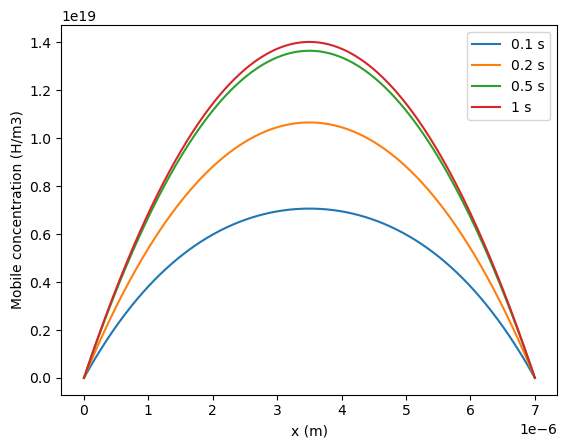

In [14]:
import matplotlib.pyplot as plt
import numpy as np

x = my_model.mesh.mesh.geometry.x[:, 0]

for t in [0.1, 0.2, 0.5, 1]:
    idx = np.where(np.isclose(profile.t, t))[0][0]
    data = profile.data[idx]
    plt.plot(x, data, label=f"{t} s")

plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.legend()
plt.show()

To solve the steady-state problem, simply set:

In [15]:
my_model.settings.transient = False
my_model.settings.stepsize = None

my_model.exports = [profile]

In [16]:
my_model.initialise()

my_model.run()

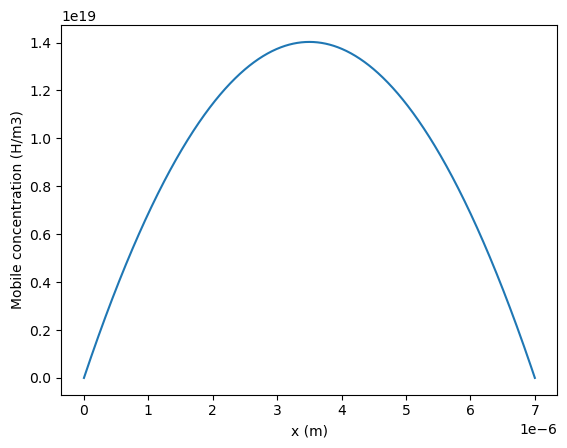

In [17]:
data = profile.data[0]
plt.plot(x, data, label=f"{t} s")
plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.show()